# Estimating the Fraction of Toxic Comments on News Articles

In this real world application, you want to find out how many toxic comments on news articles are posted every day.

### Task setup
* Data collection: You have set up a data collection pipeline, which uses the same procedure to harvest public discourse toward news articles on Reddit, Twitter/X, and YouTube, at the scale of tens of thousands per day.
  - Base dataset: `data/202108_base_hot_comments.json`
  - Labeled calibration sample: `data/202108_labeled_calibration_sample.json`
  - Target datasets: `data/2022_target_hot_comments.json`
* Black box classifiers: 
  - You have heard good things about the [Perspective API](https://perspectiveapi.com/) model, which is pre-trained to detect toxicity and widely used in academic research.
  - You also find some open source models on Github, for example, [the lexicon-based model](https://github.com/t-davidson/hate-speech-and-offensive-language) built by Davidson et al. to detect hate speech and offensive language. 
* Human annotation: You have a budget to obtain human labels for some comments from crowdsourcing platforms (e.g., MTurk), but you cannot get labels for all comments, nor can you repeat the annotation process many times.
* Some intuitions: 
  - You know there are a non-trivial amount of toxic conversations on social media, but you speculate that toxic comments will still be relatively infrequent.
  - You speculate that the classifiers may perform differently for Reddit, Twitter/X, and YouTube because the texts are very different, e.g., tweets are much shorter, Reddit is heavily moderated.

### Learning objectives
In this notebook, you will learn how to use the `pyquantifier` package to answer those two questions:
* *Calibration*: How to make a prevalence estimate for the data that you have collected as of now?
* *Extrapolation*: How to make prevalence estimates for the data that you will be collecting in the future?

## 1. Calibration phase: Prevalence estimation for the base dataset

In [1]:
import up  # go up to the project root

import json
import numpy as np
import pandas as pd

from util import get_majority_vote, obj2str, str2obj

### 1.1 Loading the labeled calibration sample

Data example below. Each comment received five human labels. The final binary label was determined by the majority vote of five labels. 

```json
{"text": "@realDailyWire It's time for the #Military #JAG Corp to arrest #JoeBiden for #HighTreason.  He has violated his oath of office to #Defend the #Constitution of the #UnitedStates of #America.  He's the head of the military, it's only fitting that he face #MilitaryJustice, #CourtMarshall.", "platform": "twitter", "platform_id": 1432170038849536000, "offense": 0.9453167533496029, "perspective_20231224": 0.15158679, "toxic_1_list": [[false, 2497], [false, 2492], [false, 1943], [false, 2590], [false, 2494]]}
```

In [2]:
calibration_sample_path = '../hot_speech_report/data/202108_labeled_calibration_sample.json'
label_mapping = {True: 'pos', False: 'neg'}

# create pandas dataframe for the calibration sample

uid_list = []
platform_list = []
offensive_score_list = []
perspective_score_list = []
toxicity_label_list = []

uid = 0
with open(calibration_sample_path, 'r') as fin:
    for line in fin:
        comment_json = json.loads(line.rstrip())
        platform = comment_json['platform']
        offensive_score = comment_json['offense']
        perspective_score = comment_json['perspective_20231224']
        toxicity_label = label_mapping[get_majority_vote([x[0] for x in comment_json['toxic_1_list']])]
        hot_label = label_mapping[get_majority_vote([(x[0] | y[0] | z[0]) for x, y, z 
                                                     in zip(comment_json['composite_hateful'], comment_json['composite_offensive'], comment_json['composite_toxic'])])]


        uid += 1
        uid_list.append(f'{platform[:1]}{uid}')
        platform_list.append(platform)
        offensive_score_list.append(offensive_score)
        perspective_score_list.append(perspective_score)
        toxicity_label_list.append(hot_label)

calibration_sample_df = pd.DataFrame.from_dict({'uid': uid_list, 
                                                'platform': platform_list, 
                                                'offensive_pos': offensive_score_list, 
                                                'offensive_neg': 1 - np.array(offensive_score_list), 
                                                'perspective_pos': perspective_score_list, 
                                                'perspective_neg': 1 - np.array(perspective_score_list), 
                                                'gt_label': toxicity_label_list})

In [3]:
calibration_sample_df.head()

,uid,platform,offensive_pos,offensive_neg,perspective_pos,perspective_neg,gt_label
0,t1,twitter,0.945317,0.054683,0.151587,0.848413,neg
1,t2,twitter,0.194814,0.805186,0.445733,0.554267,pos
2,t3,twitter,0.024257,0.975743,0.556683,0.443317,pos
3,t4,twitter,0.009499,0.990501,0.146031,0.853969,neg
4,t5,twitter,0.173215,0.826785,0.035692,0.964308,neg


In [4]:
# data profiling
for platform in ['reddit', 'twitter', 'youtube']:
    platform_calibration_sample_df = calibration_sample_df[calibration_sample_df.platform == platform]
    print(f'Labeled calibration sample has {platform_calibration_sample_df.shape[0]} comments from {platform}')
    # count the number of positives and negatives
    print(f'  Positives: {platform_calibration_sample_df[platform_calibration_sample_df.gt_label == "pos"].shape[0]}')
    print(f'  Negatives: {platform_calibration_sample_df[platform_calibration_sample_df.gt_label == "neg"].shape[0]}')

Labeled calibration sample has 1144 comments from reddit
  Positives: 332
  Negatives: 812
Labeled calibration sample has 1154 comments from twitter
  Positives: 415
  Negatives: 739
Labeled calibration sample has 1162 comments from youtube
  Positives: 496
  Negatives: 666


### 1.2 Example: Generating joint distributions for all Reddit comments

In [5]:
from pyquantifier.data import Dataset

In [6]:
# convert the pandas dataframe to pyquantifier Dataset
reddit_calibration_sample_df = calibration_sample_df[calibration_sample_df.platform == 'reddit']

# using the Perspective API scores as classifier scores
reddit_perspective_calibration_sample_dataset = Dataset(df=reddit_calibration_sample_df, 
                                                        labels=['pos', 'neg'],
                                                        column_mapping={'perspective_pos': 'pos', 'perspective_neg': 'neg'})

array([<AxesSubplot:title={'center':'Class Conditional Densities'}, xlabel='score', ylabel='density'>,
       <AxesSubplot:title={'center':'Label Density'}>,
       <AxesSubplot:title={'center':'Joint Density'}, xlabel='score', ylabel='density'>,
       <AxesSubplot:title={'center':'Classifier Score Density'}, xlabel='score', ylabel='density'>,
       <AxesSubplot:title={'center':'Calibration Curve'}, xlabel='$C(x)$', ylabel='$P(y=1|C(x))$'>],
      dtype=object)

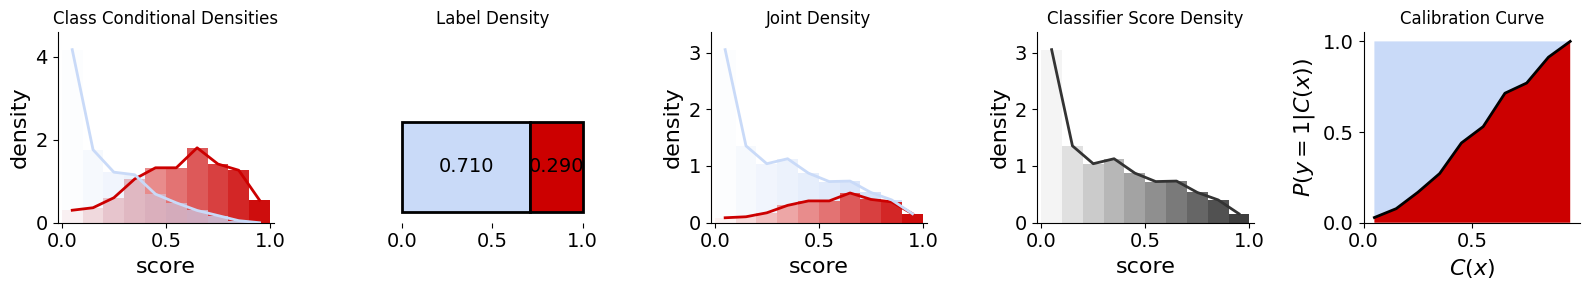

In [7]:
reddit_perspective_calibration_sample_dataset.profile_dataset()

array([<AxesSubplot:title={'center':'Class Conditional Densities'}, xlabel='score', ylabel='density'>,
       <AxesSubplot:title={'center':'Label Density'}>,
       <AxesSubplot:title={'center':'Joint Density'}, xlabel='score', ylabel='density'>,
       <AxesSubplot:title={'center':'Classifier Score Density'}, xlabel='score', ylabel='density'>,
       <AxesSubplot:title={'center':'Calibration Curve'}, xlabel='$C(x)$', ylabel='$P(y=1|C(x))$'>],
      dtype=object)

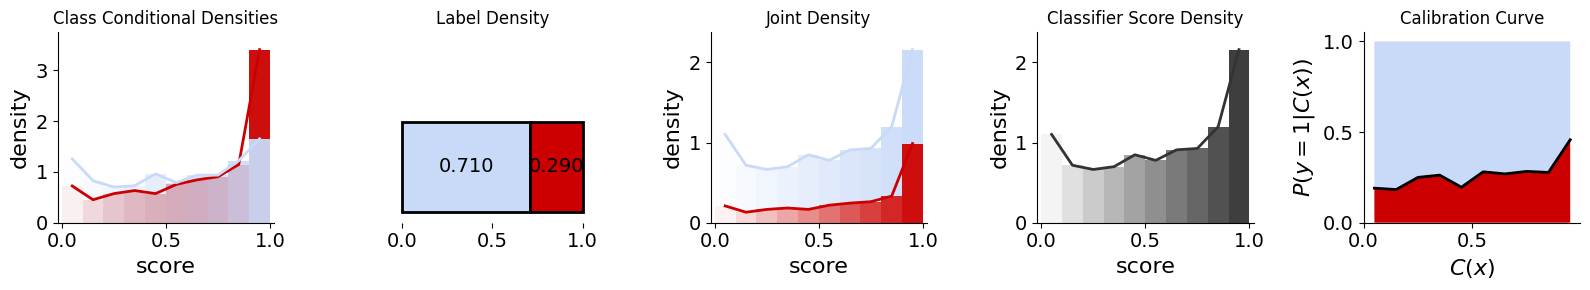

In [8]:
# using the offensive scores as classifier scores
reddit_offensive_calibration_sample_dataset = Dataset(df=reddit_calibration_sample_df, 
                                                        labels=['pos', 'neg'],
                                                        column_mapping={'offensive_pos': 'pos', 'offensive_neg': 'neg'})

reddit_offensive_calibration_sample_dataset.profile_dataset()

### 1.3 Modeling the calibration curve: Non-parametric binning vs. Platt scaling

In [9]:
# assuming the calibration curve follows Logistic Regression, aka Platt scaling
reddit_perspective_calibration_sample_dataset.update_calibration_curve(method='platt scaling')

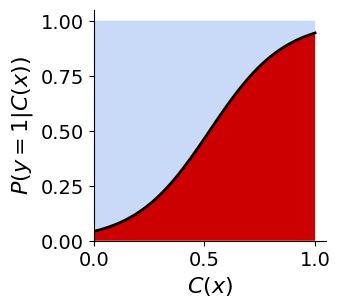

In [10]:
reddit_perspective_calibration_sample_dataset.calibration_curve.plot()

### 1.4 Creating joint distribution models for the calibration sample per classifier per platform

In [11]:
calibration_sample_model_dict = {}

for platform in ['reddit', 'twitter', 'youtube']:
    platform_calibration_sample_df = calibration_sample_df[calibration_sample_df.platform == platform]
    
    for classifier in ['perspective', 'offensive']:
        # obtain the calibration curves for different platforms and different models
        calibration_sample_model_dict[f'{platform}_{classifier}'] = Dataset(df=platform_calibration_sample_df, 
                                                                                    labels=['pos', 'neg'],
                                                                                    column_mapping={f'{classifier}_pos': 'pos', f'{classifier}_neg': 'neg'})
        # calibration_sample_model_dict[f'{platform}_{classifier}'].update_calibration_curve(method='platt scaling')

Platform: reddit, Classifier: perspective
Platform: reddit, Classifier: offensive
Platform: twitter, Classifier: perspective
Platform: twitter, Classifier: offensive
Platform: youtube, Classifier: perspective
Platform: youtube, Classifier: offensive


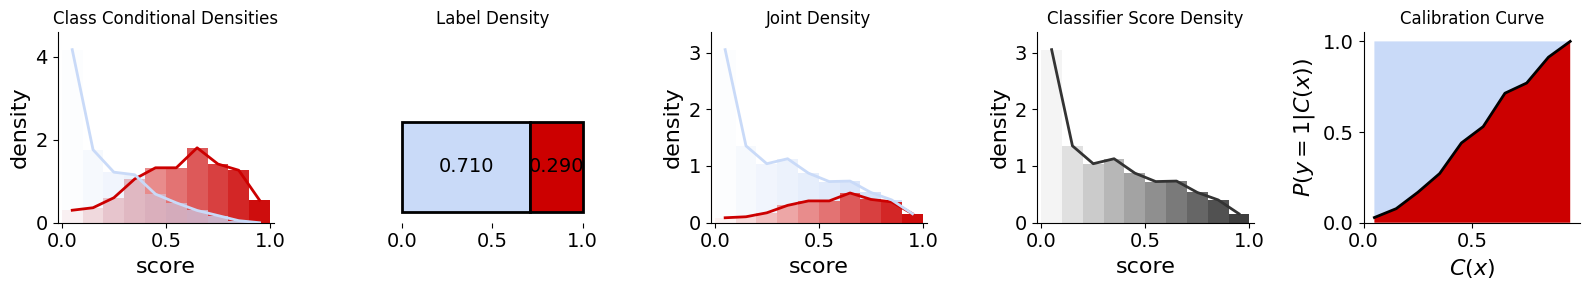

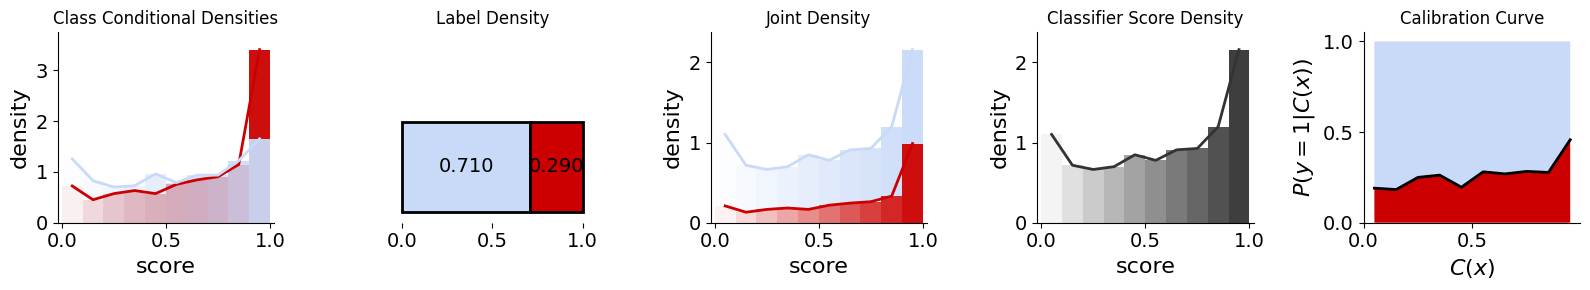

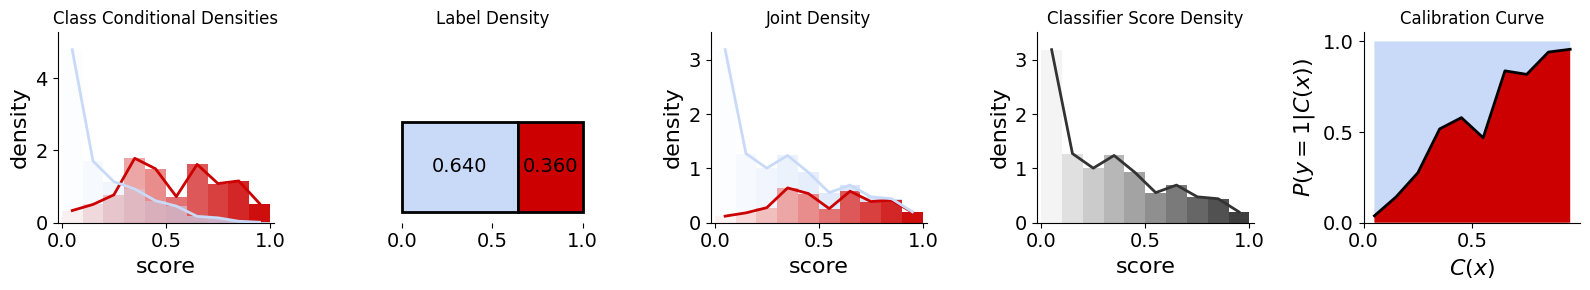

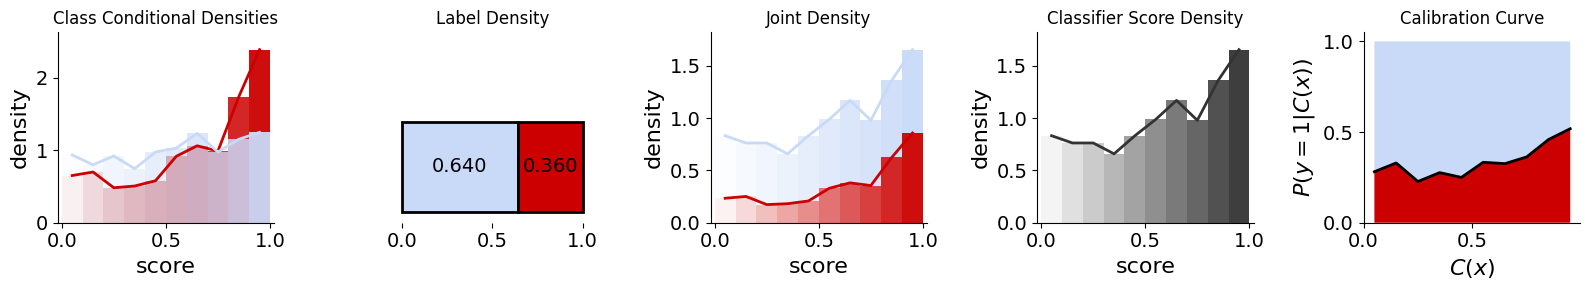

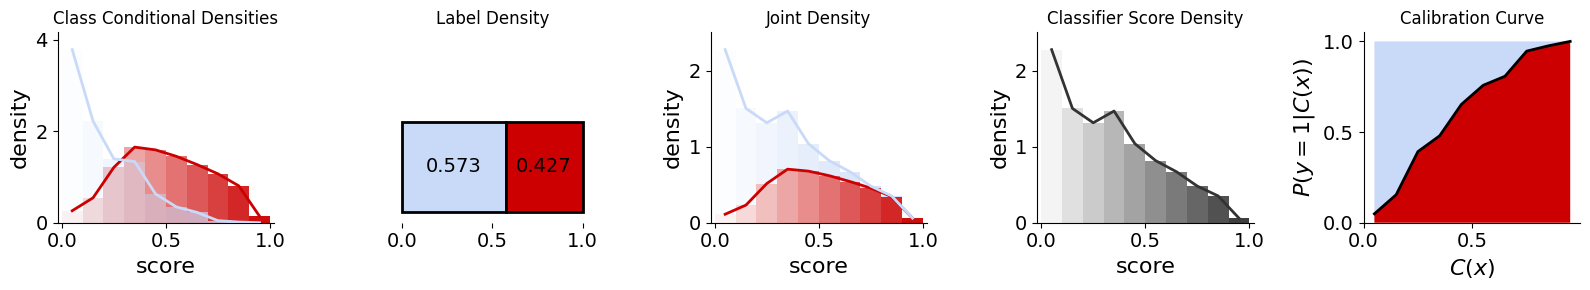

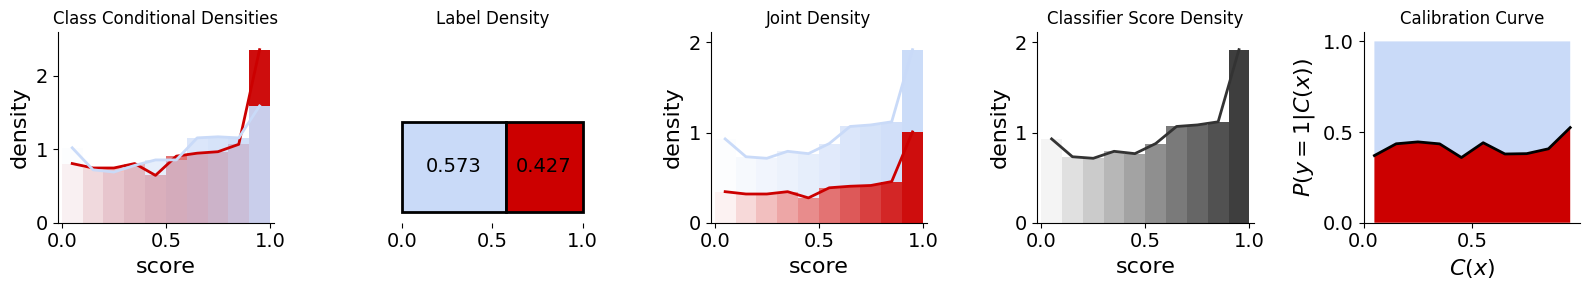

In [12]:
for platform in ['reddit', 'twitter', 'youtube']:    
    for classifier in ['perspective', 'offensive']:
        print(f'Platform: {platform}, Classifier: {classifier}')
        calibration_sample_model_dict[f'{platform}_{classifier}'].profile_dataset()

### 1.5 Loading the base dataset

Base dataset is unlabeled, but the labeled calibration sample was purposefully selected from the base dataset.

Data example below. Each line is a news article that contains classifier scores for all social media comments toward it.

```json
{"url_id": 284644, "url": "https://www.bbc.com/news/world-europe-58046183", "title": "Belarus Olympics: Krystsina Tsimanouskaya refuses 'forced' flight home", "url_start_time": "2021-08-01 12:39:29", "reported_rd_comments": [{"external_id": 1131859, "perspective": 0.584095, "offensive": 0.6593667939988046}, {"external_id": 1131867, "perspective": 0.036870047, "offensive": 0.5094569831588591}, ...], "reported_tw_replies": [{"external_id": 8953052, "perspective": 0.0025917501, "offensive": 0.8328035723864067}, {"external_id": 8953015, "perspective": 0.0051520853, "offensive": 0.6061919236489095}, ...], "reported_yt_comments": [{"external_id": 2656175, "perspective": 0.03545588, "offensive": 0.4111096124373976}, {"external_id": 2656237, "perspective": 0.2854835, "offensive": 0.27236085841958746}, ...]}
```

In [13]:
base_dataset_path = 'data/202108_base_hot_comments.json'

base_dataset_dict = {'reddit_perspective_list': [], 
                     'reddit_offensive_list': [], 
                     'twitter_perspective_list': [], 
                     'twitter_offensive_list': [], 
                     'youtube_perspective_list': [], 
                     'youtube_offensive_list': []}

with open(base_dataset_path, 'r') as fin:
    for line in fin:
        article_json = json.loads(line.rstrip())
        reported_rd_comments = article_json['reported_rd_comments']
        reported_tw_replies = article_json['reported_tw_replies']
        reported_yt_comments = article_json['reported_yt_comments']

        base_dataset_dict['reddit_perspective_list'].extend([x['perspective'] for x in reported_rd_comments])
        base_dataset_dict['reddit_offensive_list'].extend([x['offensive'] for x in reported_rd_comments])
        base_dataset_dict['twitter_perspective_list'].extend([x['perspective'] for x in reported_tw_replies])
        base_dataset_dict['twitter_offensive_list'].extend([x['offensive'] for x in reported_tw_replies])
        base_dataset_dict['youtube_perspective_list'].extend([x['perspective'] for x in reported_yt_comments])
        base_dataset_dict['youtube_offensive_list'].extend([x['offensive'] for x in reported_yt_comments])


In [14]:
print(f'The base dataset has {len(base_dataset_dict["reddit_perspective_list"]):,} Reddit comments, '
      f'{len(base_dataset_dict["twitter_perspective_list"]):,} Twitter/X replies, '
      f'and {len(base_dataset_dict["youtube_perspective_list"]):,} YouTube comments.')

The base dataset has 145,427 Reddit comments, 132,460 Twitter/X replies, and 142,707 YouTube comments.


### 1.6 Generating the classifier score density plots for the base dataset

We do not know the joint distribution between human labels and classifier scores for the base dataset. We thus can only generate the classifier score density for it (colored grey).

In [15]:
from pyquantifier.distributions import BinnedCUD

In [16]:
base_dataset_classifier_score_density_dict = {}

for platform in ['reddit', 'twitter', 'youtube']:    
    for classifier in ['perspective', 'offensive']:
        # obtain the classifier score density for different platforms and different models
        base_dataset_classifier_score_density_dict[f'{platform}_{classifier}'] = BinnedCUD(data=base_dataset_dict[f'{platform}_{classifier}_list'], num_bin=10)

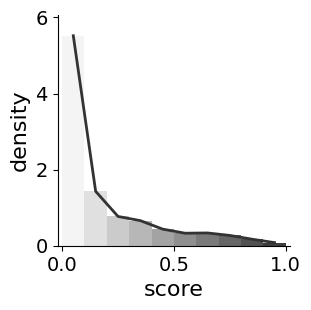

In [17]:
base_dataset_classifier_score_density_dict['reddit_perspective'].plot()

### 1.7 Comparing the classifier score density plots of the base dataset to those of the calibration sample

If the distributions of classifier scores change, it indicates a potential change in the categorical prevalence.
If the distributions are similar, the prevalence of base dataset will not be too much off that of calibration sample.

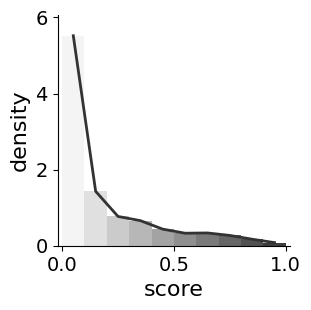

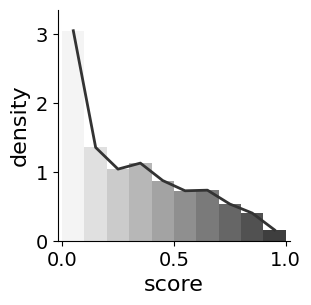

In [18]:
base_dataset_classifier_score_density_dict['reddit_perspective'].plot()
calibration_sample_model_dict['reddit_perspective'].classifier_score_distribution.plot()

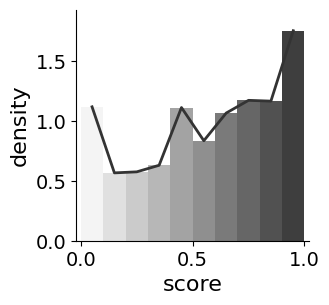

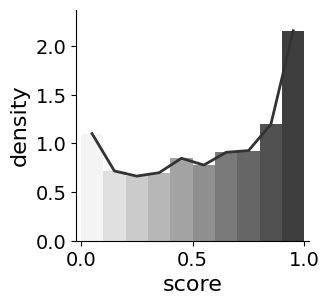

In [19]:
base_dataset_classifier_score_density_dict['reddit_offensive'].plot()
calibration_sample_model_dict['reddit_offensive'].classifier_score_distribution.plot()

### 1.8 Making prevalence estimates for the base dataset, assuming stable calibration curve

In [20]:
# modeling the calibration curves using non-parametric binning
base_dataset_model_dict = {}

for platform in ['reddit', 'twitter', 'youtube']:    
    for classifier in ['perspective', 'offensive']:
        # obtain the classifier score density for different platforms and different models
        classifier_pos_score_list = base_dataset_dict[f'{platform}_{classifier}_list']
        base_dataset_model_dict[f'{platform}_{classifier}'] = Dataset(df=pd.DataFrame.from_dict({'uid': list(range(len(classifier_pos_score_list))), 
                                                                                                 'pos': classifier_pos_score_list, 
                                                                                                 'neg': 1 - np.array(classifier_pos_score_list)}), 
                                                                      labels=['pos', 'neg'])
        
        borrowed_calibration_curve = calibration_sample_model_dict[f'{platform}_{classifier}'].calibration_curve
        est_prevalence = base_dataset_model_dict[f'{platform}_{classifier}'].extrinsic_estimate(calibration_curve=borrowed_calibration_curve)
        
        print(f'Platform: {platform}, Classifier: {classifier} -- estimated prevalence: {est_prevalence:.3f}')

Platform: reddit, Classifier: perspective -- estimated prevalence: 0.163
Platform: reddit, Classifier: offensive -- estimated prevalence: 0.282
Platform: twitter, Classifier: perspective -- estimated prevalence: 0.232
Platform: twitter, Classifier: offensive -- estimated prevalence: 0.351
Platform: youtube, Classifier: perspective -- estimated prevalence: 0.286
Platform: youtube, Classifier: offensive -- estimated prevalence: 0.420


In [21]:
# modeling the calibration curves using platt scaling
for platform in ['reddit', 'twitter', 'youtube']:    
    for classifier in ['perspective', 'offensive']:
        calibration_sample_model_dict[f'{platform}_{classifier}'].update_calibration_curve(method='platt scaling')
        
        borrowed_calibration_curve = calibration_sample_model_dict[f'{platform}_{classifier}'].calibration_curve
        est_prevalence = base_dataset_model_dict[f'{platform}_{classifier}'].extrinsic_estimate(calibration_curve=borrowed_calibration_curve)
        
        print(f'Platform: {platform}, Classifier: {classifier} -- estimated prevalence: {est_prevalence:.3f}')

Platform: reddit, Classifier: perspective -- estimated prevalence: 0.173
Platform: reddit, Classifier: offensive -- estimated prevalence: 0.289
Platform: twitter, Classifier: perspective -- estimated prevalence: 0.247
Platform: twitter, Classifier: offensive -- estimated prevalence: 0.357
Platform: youtube, Classifier: perspective -- estimated prevalence: 0.301
Platform: youtube, Classifier: offensive -- estimated prevalence: 0.429


### 1.9 Making prevalence estimates for the base dataset, borrowing stable class-conditional densities (DO NOT do this)

In [22]:
# modeling by borrowing class-conditional densities from calibration sample
for platform in ['reddit', 'twitter', 'youtube']:    
    for classifier in ['perspective', 'offensive']:
        borrowed_class_conditional_densities = calibration_sample_model_dict[f'{platform}_{classifier}'].class_conditional_densities
        est_prevalence = base_dataset_model_dict[f'{platform}_{classifier}'].intrinsic_estimate(class_conditional_densities=borrowed_class_conditional_densities)
        
        print(f'Platform: {platform}, Classifier: {classifier} -- estimated prevalence: {est_prevalence:.3f}')

Platform: reddit, Classifier: perspective -- estimated prevalence: 0.050
Platform: reddit, Classifier: offensive -- estimated prevalence: 0.110
Platform: twitter, Classifier: perspective -- estimated prevalence: 0.100
Platform: twitter, Classifier: offensive -- estimated prevalence: 0.120
Platform: youtube, Classifier: perspective -- estimated prevalence: 0.120
Platform: youtube, Classifier: offensive -- estimated prevalence: 0.000


In [ ]:
for platform in ['reddit', 'twitter', 'youtube']:
    for perspective_version in ['old', 'curr']:
        borrowed_calibration_curve = calibration_sample_model_dict[f'{platform}_{perspective_version}_perspective_model'].calibration_curve
        pos_score_list = eval(f'{platform}_{perspective_version}_perspective_list')
        num_item = len(pos_score_list)
        
        ret_list = []
        num_bootstrap = 100
        for _ in range(num_bootstrap):
            bootstrapped_cx_list = np.random.choice(pos_score_list, size=num_item, replace=True)
            bootstrapped_dataset = Dataset(df=pd.DataFrame.from_dict({'uid': list(range(num_item)), 
                                                                      'pos': bootstrapped_cx_list, 
                                                                      'neg': 1-np.array(bootstrapped_cx_list)}), 
                                           labels=['pos', 'neg'])
            
            bootstrapped_estimate = bootstrapped_dataset.extrinsic_estimate(calibration_curve=borrowed_calibration_curve)
            ret_list.append(bootstrapped_estimate)
        print(f'Platform: {platform}, Perspective API Version: {perspective_version}---estimated prevalence: {np.mean(ret_list):.3f}, {np.percentile(ret_list, 2.5):.3f}, {np.percentile(ret_list, 97.5):.3f}')
        # est_prevalence = base_dataset_model_dict[f'{platform}_{perspective_version}_model'].extrinsic_estimate(calibration_curve=borrowed_calibration_curve)
        
        # print(f'Platform: {platform}, Perspective API Version: {perspective_version}---estimated prevalence: {est_prevalence:.3f}')

Platform: reddit, Perspective API Version: old---estimated prevalence: 0.173, 0.172, 0.173
Platform: reddit, Perspective API Version: curr---estimated prevalence: 0.173, 0.172, 0.174
Platform: twitter, Perspective API Version: old---estimated prevalence: 0.242, 0.241, 0.243
Platform: twitter, Perspective API Version: curr---estimated prevalence: 0.247, 0.245, 0.248
Platform: youtube, Perspective API Version: old---estimated prevalence: 0.304, 0.302, 0.305
Platform: youtube, Perspective API Version: curr---estimated prevalence: 0.301, 0.299, 0.302


## 2. Extrapolation phase: Prevalence estimation for target datasets

### 2.1 Loading the target dataset

Target dataset is unlabeled.

Data example below. Each line is a news article that contains classifier scores for all social media comments toward it.

```json
{"url_id": 533707, "published_at": "2022-01-01 00:10:41", "selected_reddit_scores": [0.6852916, 0.39231625, 0.030034892, ...], "selected_twitter_scores": [0.008796243, 0.123468354, 0.049089402, ...], "selected_youtube_scores": [0.112746716, null, 0.6863638, ...]}
```

In [23]:
target_dataset_path = 'data/2022_target_hot_comments.json'

url_id_list = []
published_at_list = []
selected_reddit_scores_list = []
selected_twitter_scores_list = []
selected_youtube_scores_list = []

with open(target_dataset_path, 'r') as fin:
    for line in fin:
        article_json = json.loads(line.rstrip())
        url_id = article_json['url_id']
        published_at = str2obj(article_json['published_at'], '%Y-%m-%d %H:%M:%S')
        selected_reddit_scores = np.array(article_json['selected_reddit_scores'])
        selected_twitter_scores = np.array(article_json['selected_twitter_scores'])
        selected_youtube_scores = np.array(article_json['selected_youtube_scores'])
        
        url_id_list.append(url_id)
        published_at_list.append(published_at)
        selected_reddit_scores_list.append(selected_reddit_scores)
        selected_twitter_scores_list.append(selected_twitter_scores)
        selected_youtube_scores_list.append(selected_youtube_scores)
        

target_dataset_df = pd.DataFrame.from_dict({'url_id': url_id_list, 
                                            'published_at': published_at_list, 
                                            'selected_reddit_scores': selected_reddit_scores_list, 
                                            'selected_twitter_scores': selected_twitter_scores_list, 
                                            'selected_youtube_scores': selected_youtube_scores_list, 
                                            })

target_dataset_df['num_selected_comments'] = target_dataset_df['selected_reddit_scores'].apply(lambda x: len(x))


In [24]:
target_dataset_df.head(2)

,url_id,published_at,selected_reddit_scores,selected_twitter_scores,selected_youtube_scores,num_selected_comments
0,533707,2022-01-01 00:10:41,"[0.6852916, 0.39231625, 0.030034892, 0.2164243...","[0.008796243, 0.123468354, 0.049089402, 0.5357...","[0.028385026, 0.015330595, 0.13214645, 0.15932...",99
1,532676,2022-01-01 01:48:09,[0.020607091],[0.39842087],[0.10089093],1


In [25]:
print(f'The target dataset has {target_dataset_df.shape[0]:,} articles, '
      f'{target_dataset_df["selected_reddit_scores"].apply(lambda x: len(x)).sum():,} Reddit comments, '
      f'{target_dataset_df["selected_twitter_scores"].apply(lambda x: len(x)).sum():,} Twitter/X replies, '
      f'{target_dataset_df["selected_youtube_scores"].apply(lambda x: len(x)).sum():,} and YouTube comments.')

The target dataset has 27,001 articles, 2,063,543 Reddit comments, 2,063,543 Twitter/X replies, 2,063,543 and YouTube comments.


### 2.2 Generating the classifier score density plots for the target dataset

We thus can only generate the classifier score density for the target dataset (colored grey).

In [26]:
target_dataset_classifier_score_density_dict = {}

for platform in ['reddit', 'twitter', 'youtube']:    
    # obtain the classifier score density for different platforms and different models
    selected_platform_scores = np.concatenate(target_dataset_df[f'selected_{platform}_scores'].values)
    nna_selected_platform_scores = selected_platform_scores[~pd.isnull(selected_platform_scores)]
    target_dataset_classifier_score_density_dict[f'{platform}_perspective'] = BinnedCUD(data=nna_selected_platform_scores, num_bin=10)

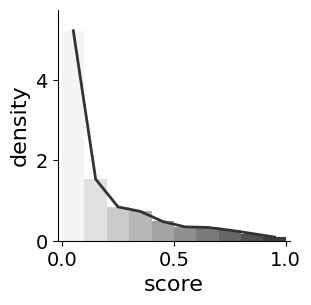

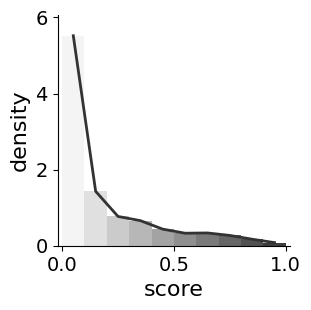

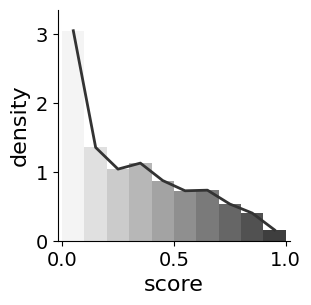

In [27]:
target_dataset_classifier_score_density_dict['reddit_perspective'].plot()
base_dataset_classifier_score_density_dict['reddit_perspective'].plot()
calibration_sample_model_dict['reddit_perspective'].classifier_score_distribution.plot()

### 2.3 Example: Slicing a time period with more prominent change

In [28]:
# select target_dataset_df with `published_at` between 2022-02-28 (inclusive) and 2022-03-07 (exclusive)
example_target_dataset_df = target_dataset_df[(target_dataset_df.published_at >= '2022-02-28') & (target_dataset_df.published_at < '2022-03-07')]

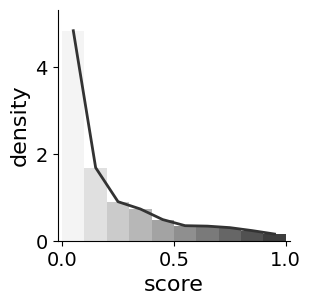

In [29]:
example_selected_platform_scores = np.concatenate(example_target_dataset_df['selected_reddit_scores'].values)
example_nna_selected_platform_scores = example_selected_platform_scores[~pd.isnull(example_selected_platform_scores)]

BinnedCUD(data=example_nna_selected_platform_scores, num_bin=10).plot()

In [37]:
# modeling the calibration curves using platt scaling
target_dataset_model_dict = {}

def estimate_target_dataset(target_df, platform='reddit', classifier='perspective', calibration_curve=None, class_conditional_densities=None):
    if calibration_curve is None and class_conditional_densities is None:
        raise ValueError('Either calibration_curve or class_conditional_densities must be provided.')
    
    classifier_pos_score_array = np.concatenate(target_df[f'selected_{platform}_scores'].values)
    nna_classifier_pos_score_array = classifier_pos_score_array[~pd.isnull(classifier_pos_score_array)]
    
    print(f'Platform: {platform}, Classifier: {classifier} -- number of non-null scores: {len(nna_classifier_pos_score_array):,}')
    
    target_dataset_model = Dataset(df=pd.DataFrame.from_dict({'uid': list(range(len(nna_classifier_pos_score_array))), 
                                                        'pos': nna_classifier_pos_score_array, 
                                                        'neg': 1 - nna_classifier_pos_score_array}), 
                             labels=['pos', 'neg'])
    
    if calibration_curve is not None:
        est_prevalence = target_dataset_model.extrinsic_estimate(calibration_curve=calibration_curve)
        print(f'Assuming stable calibration curve -- estimated prevalence: {est_prevalence:.3f}')
    elif class_conditional_densities is not None:
        est_prevalence = target_dataset_model.intrinsic_estimate(class_conditional_densities=class_conditional_densities)
        print(f'Assuming stable class-conditional densities -- estimated prevalence: {est_prevalence:.3f}')

In [38]:
for platform in ['reddit', 'twitter', 'youtube']:    
    for classifier in ['perspective']:
        calibration_sample_model_dict[f'{platform}_{classifier}'].update_calibration_curve(method='platt scaling')        
        borrowed_calibration_curve = calibration_sample_model_dict[f'{platform}_{classifier}'].calibration_curve
        
        estimate_target_dataset(target_dataset_df, platform=platform, classifier=classifier, calibration_curve=borrowed_calibration_curve)

Platform: reddit, Classifier: perspective -- number of non-null scores: 2,053,206
Assuming stable calibration curve -- estimated prevalence: 0.178
Platform: twitter, Classifier: perspective -- number of non-null scores: 2,030,381
Assuming stable calibration curve -- estimated prevalence: 0.243
Platform: youtube, Classifier: perspective -- number of non-null scores: 2,032,623
Assuming stable calibration curve -- estimated prevalence: 0.299


In [39]:
example_target_dataset_df = target_dataset_df[(target_dataset_df.published_at >= '2022-02-28') & (target_dataset_df.published_at < '2022-03-07')]

for platform in ['reddit', 'twitter', 'youtube']:    
    for classifier in ['perspective']:
        calibration_sample_model_dict[f'{platform}_{classifier}'].update_calibration_curve(method='platt scaling')        
        borrowed_calibration_curve = calibration_sample_model_dict[f'{platform}_{classifier}'].calibration_curve
        
        estimate_target_dataset(example_target_dataset_df, platform=platform, classifier=classifier, calibration_curve=borrowed_calibration_curve)

Platform: reddit, Classifier: perspective -- number of non-null scores: 71,696
Assuming stable calibration curve -- estimated prevalence: 0.194
Platform: twitter, Classifier: perspective -- number of non-null scores: 70,883
Assuming stable calibration curve -- estimated prevalence: 0.259
Platform: youtube, Classifier: perspective -- number of non-null scores: 70,525
Assuming stable calibration curve -- estimated prevalence: 0.320


### 2.4 Making prevalence estimates for the target dataset, borrowing stable class-conditional densities

In [52]:
# modeling by borrowing class-conditional densities from calibration sample
for platform in ['reddit', 'twitter', 'youtube']:    
    for classifier in ['perspective']:
        borrowed_class_conditional_densities = calibration_sample_model_dict[f'{platform}_{classifier}'].class_conditional_densities
        
        estimate_target_dataset(example_target_dataset_df, platform=platform, classifier=classifier, class_conditional_densities=borrowed_class_conditional_densities)

Platform: reddit, Classifier: perspective -- number of non-null scores: 71,696
Assuming stable class-conditional densities -- estimated prevalence: 0.090
Platform: twitter, Classifier: perspective -- number of non-null scores: 70,883
Assuming stable class-conditional densities -- estimated prevalence: 0.110
Platform: youtube, Classifier: perspective -- number of non-null scores: 70,525
Assuming stable class-conditional densities -- estimated prevalence: 0.160


In [46]:
from pyquantifier.distributions import ExtrinsicJointDistribution

base_jd_dict = {}

for platform in ['reddit', 'twitter', 'youtube']:
    for classifier in ['perspective']:
        base_jd_dict[f'{platform}_{classifier}'] = ExtrinsicJointDistribution(labels=['pos', 'neg'], 
                                                                                      classifier_score_distribution=base_dataset_classifier_score_density_dict[f'{platform}_{classifier}'], 
                                                                                      calibration_curve=calibration_sample_model_dict[f'{platform}_{classifier}'].calibration_curve)

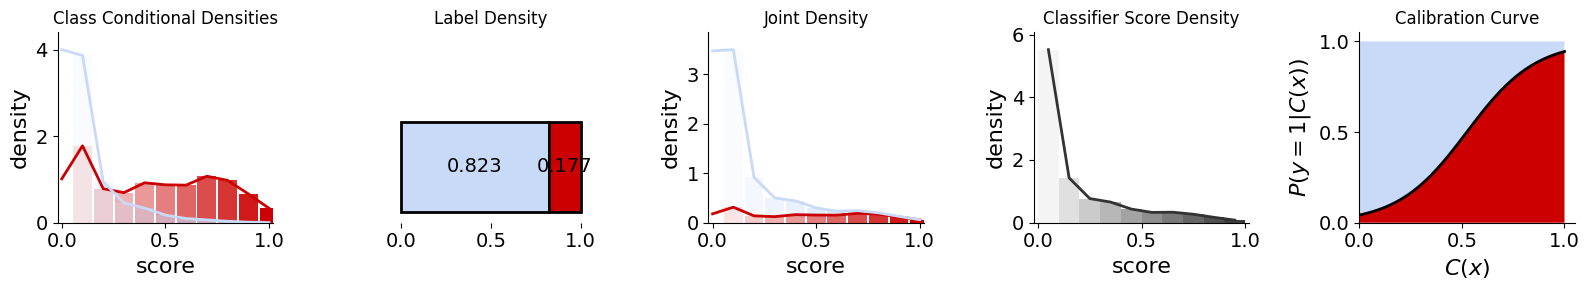

In [47]:
base_jd_dict['reddit_perspective'].plot_five_distributions()

array([<AxesSubplot:title={'center':'Class Conditional Densities'}, xlabel='score', ylabel='density'>,
       <AxesSubplot:title={'center':'Label Density'}>,
       <AxesSubplot:title={'center':'Joint Density'}, xlabel='score', ylabel='density'>,
       <AxesSubplot:title={'center':'Classifier Score Density'}, xlabel='score', ylabel='density'>,
       <AxesSubplot:title={'center':'Calibration Curve'}, xlabel='$C(x)$', ylabel='$P(y=1|C(x))$'>],
      dtype=object)

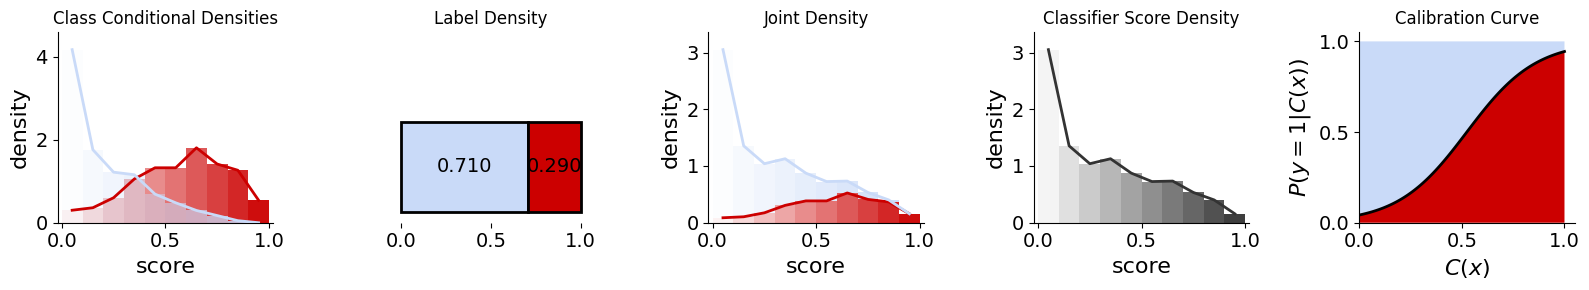

In [48]:
calibration_sample_model_dict['reddit_perspective'].profile_dataset()

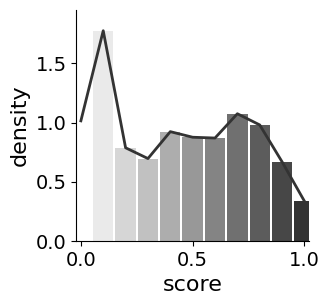

In [49]:
base_jd_dict['reddit_perspective'].class_conditional_densities['pos'].plot()

In [53]:
# modeling by borrowing class-conditional densities from calibration sample
for platform in ['reddit', 'twitter', 'youtube']:    
    for classifier in ['perspective']:
        borrowed_class_conditional_densities = base_jd_dict[f'{platform}_{classifier}'].class_conditional_densities
        
        estimate_target_dataset(example_target_dataset_df, platform=platform, classifier=classifier, class_conditional_densities=borrowed_class_conditional_densities)

Platform: reddit, Classifier: perspective -- number of non-null scores: 71,696
Assuming stable class-conditional densities -- estimated prevalence: 0.280
Platform: twitter, Classifier: perspective -- number of non-null scores: 70,883
Assuming stable class-conditional densities -- estimated prevalence: 0.330
Platform: youtube, Classifier: perspective -- number of non-null scores: 70,525
Assuming stable class-conditional densities -- estimated prevalence: 0.400
